In [ ]:
!pip install torchmetrics

In [ ]:
!pip install pytorch_accelerated

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt

In [9]:
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
 print('User uploaded file "{name}" with length {length} bytes'.format(
     name=fn, length=len(uploaded[fn])))

In [2]:
employees = pd.read_csv('employees.csv', sep=';')

In [3]:
data_df = pd.read_csv('new_df.csv').drop(columns='Unnamed: 0')

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [5]:
data_df['rating_cut']=pd.qcut(data_df.rating, 5)

In [6]:
data_df['rating_encoded'] = le.fit_transform(data_df.rating_cut)
data_df['rating_encoded'] = data_df['rating_encoded']+1

In [7]:
data_df[['rating_cut','rating_encoded']].drop_duplicates().sort_values('rating_encoded')

,rating_cut,rating_encoded
3,"(-15.814, 0.0328]",1
9,"(0.0328, 1.458]",2
1,"(1.458, 2.85]",3
18,"(2.85, 4.591]",4
0,"(4.591, 17.737]",5


In [8]:
data_df[['rating_cut','rating_encoded']].groupby('rating_encoded')['rating_encoded'].count()

rating_encoded
1    1681
2    1681
3    1680
4    1681
5    1681
Name: rating_encoded, dtype: int64

In [9]:
data_df['rating'] = data_df.rating_encoded

In [10]:
data_df = data_df.drop(columns=['rating_cut', 'rating_encoded'])

In [11]:
ratings_df = data_df[['user_id', 'title', 'rating', 'unix_timestamp']]

In [12]:
ratings_df["user_id"] = ratings_df["user_id"].astype(str)

<ipython-input-12-8d0edbd79945>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df["user_id"] = ratings_df["user_id"].astype(str)


Общая статистика о наборе данных

In [13]:
ratings_per_user = ratings_df.groupby('user_id').rating.count()
ratings_per_item = ratings_df.groupby('title').rating.count()

print(f"Total No. of users: {len(ratings_df.user_id.unique())}")
print(f"Total No. of items: {len(ratings_df.title.unique())}")
print("\n")

print(f"Max observed rating: {ratings_df.rating.max()}")
print(f"Min observed rating: {ratings_df.rating.min()}")
print("\n")

print(f"Max no. of user ratings: {ratings_per_user.max()}")
print(f"Min no. of user ratings: {ratings_per_user.min()}")
print(f"Median no. of ratings per user: {ratings_per_user.median()}")
print("\n")

print(f"Max no. of item ratings: {ratings_per_item.max()}")
print(f"Min no. of item ratings: {ratings_per_item.min()}")
print(f"Median no. of ratings per item: {ratings_per_item.median()}")


Total No. of users: 1677
Total No. of items: 92


Max observed rating: 5
Min observed rating: 1


Max no. of user ratings: 24
Min no. of user ratings: 1
Median no. of ratings per user: 4.0


Max no. of item ratings: 348
Min no. of item ratings: 15
Median no. of ratings per item: 59.0


**Разделение на training/validation**

Поскольку мы намерены обучать модель трансформатора на последовательностях оценок, то набор случайных строк не является хорошим представлением задачи, которую мы пытаемся смоделировать, т.к. для некоторых пользователей оценки из середины последовательности окажутся в наборе проверки. Поэтому будем использовать стратегию"проверка с исключением одного", при которой мы выбираем последний хронологический рейтинг для каждого пользователя, учитывая, что он оценил некоторое количество элементов, превышающее определенный порог.
Определим функцию для получения последних n для каждого пользователя.

In [14]:
def get_last_n_ratings_by_user(
    df, n, min_ratings_per_user=1, user_colname="user_id", timestamp_colname="unix_timestamp"
):
    return (
        df.groupby(user_colname)
        .filter(lambda x: len(x) >= min_ratings_per_user)
        .sort_values(timestamp_colname)
        .groupby(user_colname)
        .tail(n)
        .sort_values(user_colname)
    )

In [15]:
get_last_n_ratings_by_user(ratings_df, 1)

,user_id,title,rating,unix_timestamp
5105,00411460-f7c9-2d21-24a6-7ea0f4cb5f85,Эффективное планирование и организация работы ...,4,2023-09-08
2182,006f52e9-102a-8d3b-e2fe-5614f42ba989,Использование социальных сетей для улучшения к...,3,2023-11-07
2787,00a03ec6-533c-a7f5-c644-d198d815329c,Использование эмоционального интеллекта в обще...,5,2023-10-15
2788,00ac8ed3-b432-7bdd-4ebb-ebcb2ba10a00,Использование эмоционального интеллекта в обще...,1,2023-09-28
3162,00e26af6-ac3b-1c1c-49d7-c3d79c60d000,Техники переговоров и урегулирования спорных в...,4,2023-09-29
...,...,...,...,...
880,ff1418e8-cc99-3fe8-abcf-e3ce2003e5c5,Развитие навыков эмпатии в клиентском обслужив...,1,2023-06-15
2942,ff49cc40-a889-0e6a-60f4-0ff3026d2730,Использование эмоционального интеллекта в обще...,1,2023-06-01
4381,fface838-5abb-f94b-4593-a0ed53a0c70f,Управление ожиданиями и эмоциями клиентов в ус...,5,2023-11-03
8129,ffedf5be-3a86-e2ee-281d-54cdc97bc1cf,Развитие навыков адаптации к различным типам к...,2,2023-11-02


Теперь определим другую функцию, чтобы пометить последние n оценок каждого пользователя в качестве нашего набора проверки с помощью столбца is_valid:

In [16]:
def mark_last_n_ratings_as_validation_set(
    df, n, min_ratings=1, user_colname="user_id", timestamp_colname="unix_timestamp"
):
    df["is_valid"] = False
    df.loc[
        get_last_n_ratings_by_user(
            df,
            n,
            min_ratings,
            user_colname=user_colname,
            timestamp_colname=timestamp_colname,
        ).index,
        "is_valid",
    ] = True

    return df

In [17]:
mark_last_n_ratings_as_validation_set(ratings_df, 1)

,user_id,title,rating,unix_timestamp,is_valid
0,0c048b3a-434e-49e6-55c1-247efb389cec,Основы клиентского сервиса: Практический подход,5,2023-03-24,False
1,1543843a-4723-ed2a-b08e-18053ae6dc5b,Основы клиентского сервиса: Практический подход,3,2023-11-05,True
2,1c383cd3-0b7c-298a-b502-93adfecb7b18,Основы клиентского сервиса: Практический подход,5,2023-04-06,False
3,24681928-425f-5a91-3350-4de568f5f6df,Основы клиентского сервиса: Практический подход,1,2023-03-04,False
4,26e359e8-3860-db1d-11b6-acca57d8ea88,Основы клиентского сервиса: Практический подход,1,2023-04-27,False
...,...,...,...,...,...
8399,f29c21d4-897f-7894-8b91-f03172341b7b,Стратегии управления ожиданиями и эмоциями кли...,2,2023-10-15,True
8400,f3144cef-e89a-60d6-a1af-af7859c5076b,Стратегии управления ожиданиями и эмоциями кли...,4,2023-08-06,False
8401,f80ff32e-08a2-5270-b5f2-52ce39522f72,Стратегии управления ожиданиями и эмоциями кли...,1,2023-07-22,False
8402,f899139d-f5e1-0593-9643-1415e770c6dd,Стратегии управления ожиданиями и эмоциями кли...,5,2023-07-14,False


In [18]:
train_df = ratings_df[ratings_df.is_valid==False]
valid_df = ratings_df[ratings_df.is_valid==True]

In [19]:
len(valid_df), ratings_df.shape, train_df.shape

(1677, (8404, 5), (6727, 5))

**Baseline Model**

Создадим базовую модель для сравнения всех будущих подходов. Спрогнозируем средний рейтинг, независимо от контекста. Поскольку на среднее значение могут сильно влиять выбросы, давайте воспользуемся для этого медианой.

In [20]:
median_rating = train_df.rating.median()

In [21]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

predictions = np.array([median_rating]* len(valid_df))

mae = mean_absolute_error(valid_df.rating, predictions)
mse = mean_squared_error(valid_df.rating, predictions)
rmse = math.sqrt(mse)

print(f'mae: {mae}')
print(f'mse: {mse}')
print(f'rmse: {rmse}')

mae: 1.1997614788312463
mse: 1.9952295766249255
rmse: 1.4125259560889227


**Матричная факторизация со смещением**

Преобразуем название курса в целочисленный формат, так же закодируем юзер ид

In [22]:
user_lookup = {v: i+1 for i, v in enumerate(ratings_df['user_id'].unique())}

In [23]:
course_lookup = {v: i+1 for i, v in enumerate(ratings_df['title'].unique())}

In [24]:
from torch.utils.data import Dataset

class UserItemRatingDataset(Dataset):
    def __init__(self, df, course_lookup, user_lookup):
        self.df = df
        self.course_lookup = course_lookup
        self.user_lookup = user_lookup

    def __getitem__(self, index):
        row = self.df.iloc[index]
        user_id = self.user_lookup[row.user_id]
        course_id = self.course_lookup[row.title]

        rating = torch.tensor(row.rating, dtype=torch.float32)

        return (user_id, course_id), rating

    def __len__(self):
        return len(self.df)


In [25]:
train_dataset = UserItemRatingDataset(train_df, course_lookup, user_lookup)
valid_dataset = UserItemRatingDataset(valid_df, course_lookup, user_lookup)

In [26]:
import torch
from torch import nn

class MfDotBias(nn.Module):

    def __init__(
        self, n_factors, n_users, n_items, ratings_range=None, use_biases=True
    ):
        super().__init__()
        self.bias = use_biases
        self.y_range = ratings_range
        self.user_embedding = nn.Embedding(n_users+1, n_factors, padding_idx=0)
        self.item_embedding = nn.Embedding(n_items+1, n_factors, padding_idx=0)

        if use_biases:
            self.user_bias = nn.Embedding(n_users+1, 1, padding_idx=0)
            self.item_bias = nn.Embedding(n_items+1, 1, padding_idx=0)

    def forward(self, inputs):
        users, items = inputs
        dot = self.user_embedding(users) * self.item_embedding(items)
        result = dot.sum(1)
        if self.bias:
            result = (
                result + self.user_bias(users).squeeze() + self.item_bias(items).squeeze()
            )

        if self.y_range is None:
            return result
        else:
            return (
                torch.sigmoid(result) * (self.y_range[1] - self.y_range[0])
                + self.y_range[0]
            )

Слой внедрения — это таблица поиска, указываем размер слоя внедрения - количество уникальных элементов, наблюдаемых в полном наборе данных, а не только в обучающем наборе. Указываем встраивание заполнения по индексу 0, которое можно использовать для любых неизвестных значений. PyTorch справляется с этим, устанавливая для этой записи нулевой вектор, который не обновляется во время обучения.

Кроме того, поскольку это задача регрессии, диапазон, который может предсказать модель, потенциально неограничен. Изменим архитектуру, чтобы ограничить этот диапазон перед обучением. Применим сигмоидальную функцию к выходным данным модели, которая ограничивает диапазон от 0 до 1, а затем масштабируя ее в пределах диапазона, который мы можем определить.

**PyTorch accelerated**

In [27]:
from functools import partial

from pytorch_accelerated import Trainer, notebook_launcher
from pytorch_accelerated.trainer import TrainerPlaceholderValues, DEFAULT_CALLBACKS
from pytorch_accelerated.callbacks import EarlyStoppingCallback, SaveBestModelCallback, TrainerCallback, StopTrainingError
import torchmetrics

INFO:pytorch_accelerated:Setting random seeds


Поскольку ускорение pytorch по умолчанию отслеживает только потери при обучении и проверке, создадим обратный вызов для отслеживания наших показателей.

In [28]:
class RecommenderMetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics = torchmetrics.MetricCollection(
            {
                "mse": torchmetrics.MeanSquaredError(),
                "mae": torchmetrics.MeanAbsoluteError(),
            }
        )

    def _move_to_device(self, trainer):
        self.metrics.to(trainer.device)

    def on_training_run_start(self, trainer, **kwargs):
        self._move_to_device(trainer)

    def on_evaluation_run_start(self, trainer, **kwargs):
        self._move_to_device(trainer)

    def on_eval_step_end(self, trainer, batch, batch_output, **kwargs):
        preds = batch_output["model_outputs"]
        self.metrics.update(preds, batch[1])

    def on_eval_epoch_end(self, trainer, **kwargs):
        metrics = self.metrics.compute()

        mse = metrics["mse"].cpu()
        trainer.run_history.update_metric("mae", metrics["mae"].cpu())
        trainer.run_history.update_metric("mse", mse)
        trainer.run_history.update_metric("rmse",  math.sqrt(mse))

        self.metrics.reset()

Ускорение PyTorch предоставляет функцию Notebook_launcher, которая позволяет нам запускать обучающие прогоны с несколькими графическими процессорами прямо из блокнота. Чтобы использовать это, все, что нам нужно сделать, это определить функцию обучения, которая создает экземпляр нашего объекта Trainer и вызывает метод train.

Такие компоненты, как модель и набор данных, можно определить в любом месте, но важно, чтобы экземпляр тренажера создавался только в рамках функции обучения.

In [29]:
def train_mf_model():
    model = MfDotBias(
        120, len(user_lookup), len(course_lookup), ratings_range=[0.5, 5.5]
    )
    loss_func = torch.nn.MSELoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

    create_sched_fn = partial(
        torch.optim.lr_scheduler.OneCycleLR,
        max_lr=0.01,
        epochs=TrainerPlaceholderValues.NUM_EPOCHS,
        steps_per_epoch=TrainerPlaceholderValues.NUM_UPDATE_STEPS_PER_EPOCH,
    )

    trainer = Trainer(
        model=model,
        loss_func=loss_func,
        optimizer=optimizer,
        callbacks=(
            RecommenderMetricsCallback,
            *DEFAULT_CALLBACKS,
            SaveBestModelCallback(watch_metric="mae"),
            EarlyStoppingCallback(
                early_stopping_patience=2,
                early_stopping_threshold=0.001,
                watch_metric="mae",
            ),
        ),
    )

    trainer.train(
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        num_epochs=30,
        per_device_batch_size=32,
        create_scheduler_fn=create_sched_fn,
    )


In [30]:
notebook_launcher(train_mf_model, num_processes=2)

Launching training on one CPU.

Starting training run

Starting epoch 1


  0%|          | 0/211 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 96%|█████████▌| 202/211 [00:02<00:00, 84.68it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 211/211 [00:02<00:00, 79.48it/s]



train_loss_epoch: 7.258767604827881


100%|██████████| 53/53 [00:00<00:00, 94.55it/s] 



mse: 7.462264060974121

mae: 2.3409464359283447

eval_loss_epoch: 7.462263584136963

rmse: 2.731714491116178

Starting epoch 2


100%|██████████| 211/211 [00:02<00:00, 78.95it/s]



train_loss_epoch: 6.875697612762451


100%|██████████| 53/53 [00:00<00:00, 95.72it/s] 



mse: 7.459092140197754

mae: 2.3411307334899902

eval_loss_epoch: 7.459090709686279

rmse: 2.7311338561479834
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 1/2

Starting epoch 3


100%|██████████| 211/211 [00:03<00:00, 56.64it/s]



train_loss_epoch: 6.189195156097412


100%|██████████| 53/53 [00:00<00:00, 93.16it/s] 



mse: 7.4495062828063965

mae: 2.3389430046081543

eval_loss_epoch: 7.449507236480713

rmse: 2.7293783693006723

Improvement of 0.0020034313201904297 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 4


100%|██████████| 211/211 [00:02<00:00, 81.29it/s]



train_loss_epoch: 5.5987467765808105


100%|██████████| 53/53 [00:00<00:00, 90.37it/s] 



mse: 7.416579723358154

mae: 2.3304569721221924

eval_loss_epoch: 7.416578769683838

rmse: 2.7233398104823707

Improvement of 0.008486032485961914 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 5


100%|██████████| 211/211 [00:02<00:00, 82.76it/s]



train_loss_epoch: 5.336017608642578


100%|██████████| 53/53 [00:00<00:00, 89.80it/s] 



mse: 7.393068313598633

mae: 2.326970100402832

eval_loss_epoch: 7.393068313598633

rmse: 2.7190197339479965

Improvement of 0.0034868717193603516 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 6


100%|██████████| 211/211 [00:02<00:00, 81.50it/s]



train_loss_epoch: 5.194315433502197


100%|██████████| 53/53 [00:00<00:00, 63.95it/s]



mse: 7.329566955566406

mae: 2.3124096393585205

eval_loss_epoch: 7.329566955566406

rmse: 2.7073172986494223

Improvement of 0.014560461044311523 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 7


100%|██████████| 211/211 [00:03<00:00, 60.98it/s]



train_loss_epoch: 5.099026679992676


100%|██████████| 53/53 [00:00<00:00, 91.71it/s] 



mse: 7.245285511016846

mae: 2.2873098850250244

eval_loss_epoch: 7.245286464691162

rmse: 2.6917068025728295

Improvement of 0.025099754333496094 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 8


100%|██████████| 211/211 [00:02<00:00, 81.28it/s]



train_loss_epoch: 4.958422660827637


100%|██████████| 53/53 [00:00<00:00, 90.04it/s] 



mse: 7.162961959838867

mae: 2.2753586769104004

eval_loss_epoch: 7.162961959838867

rmse: 2.676371043005597

Improvement of 0.011951208114624023 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 9


100%|██████████| 211/211 [00:02<00:00, 79.34it/s]



train_loss_epoch: 4.831874370574951


100%|██████████| 53/53 [00:00<00:00, 93.19it/s] 



mse: 7.165039539337158

mae: 2.2758102416992188

eval_loss_epoch: 7.1650390625

rmse: 2.6767591485483258
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 1/2

Starting epoch 10


100%|██████████| 211/211 [00:03<00:00, 68.58it/s]



train_loss_epoch: 4.729948043823242


100%|██████████| 53/53 [00:00<00:00, 56.07it/s]



mse: 7.012661933898926

mae: 2.237222671508789

eval_loss_epoch: 7.012660980224609

rmse: 2.648143110539709

Improvement of 0.03813600540161133 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 11


100%|██████████| 211/211 [00:02<00:00, 73.46it/s]



train_loss_epoch: 4.642194747924805


100%|██████████| 53/53 [00:00<00:00, 88.45it/s] 



mse: 6.990523815155029

mae: 2.2396187782287598

eval_loss_epoch: 6.990523338317871

rmse: 2.643959873968406
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 1/2

Starting epoch 12


100%|██████████| 211/211 [00:02<00:00, 77.59it/s]



train_loss_epoch: 4.485124588012695


100%|██████████| 53/53 [00:00<00:00, 89.57it/s] 



mse: 6.853606700897217

mae: 2.2032310962677

eval_loss_epoch: 6.853605270385742

rmse: 2.6179393997755596

Improvement of 0.03399157524108887 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 13


100%|██████████| 211/211 [00:02<00:00, 80.76it/s]



train_loss_epoch: 4.365355014801025


100%|██████████| 53/53 [00:00<00:00, 93.93it/s] 



mse: 6.831207275390625

mae: 2.207122564315796

eval_loss_epoch: 6.831207752227783

rmse: 2.6136578344134156
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 1/2

Starting epoch 14


100%|██████████| 211/211 [00:03<00:00, 56.97it/s]



train_loss_epoch: 4.2216105461120605


100%|██████████| 53/53 [00:00<00:00, 92.40it/s] 



mse: 6.7586259841918945

mae: 2.1948928833007812

eval_loss_epoch: 6.758625030517578

rmse: 2.599735752762556

Improvement of 0.008338212966918945 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 15


100%|██████████| 211/211 [00:02<00:00, 82.26it/s]



train_loss_epoch: 4.098671913146973


100%|██████████| 53/53 [00:00<00:00, 90.61it/s] 



mse: 6.683478355407715

mae: 2.1756327152252197

eval_loss_epoch: 6.683478355407715

rmse: 2.5852424171453854

Improvement of 0.019260168075561523 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 16


100%|██████████| 211/211 [00:02<00:00, 78.31it/s]



train_loss_epoch: 3.9909071922302246


100%|██████████| 53/53 [00:00<00:00, 86.91it/s]



mse: 6.6405768394470215

mae: 2.1758360862731934

eval_loss_epoch: 6.640575408935547

rmse: 2.5769316714742403
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 1/2

Starting epoch 17


100%|██████████| 211/211 [00:02<00:00, 80.59it/s]



train_loss_epoch: 3.881601572036743


100%|██████████| 53/53 [00:00<00:00, 58.53it/s]



mse: 6.605065822601318

mae: 2.1657049655914307

eval_loss_epoch: 6.605065822601318

rmse: 2.5700322610039974

Improvement of 0.009927749633789062 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 18


100%|██████████| 211/211 [00:03<00:00, 62.57it/s]



train_loss_epoch: 3.7642693519592285


100%|██████████| 53/53 [00:00<00:00, 87.23it/s]



mse: 6.544286727905273

mae: 2.1547601222991943

eval_loss_epoch: 6.544285297393799

rmse: 2.5581803548431203

Improvement of 0.010944843292236328 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 19


100%|██████████| 211/211 [00:04<00:00, 49.21it/s]



train_loss_epoch: 3.6997902393341064


100%|██████████| 53/53 [00:00<00:00, 89.60it/s] 



mse: 6.47628116607666

mae: 2.1392552852630615

eval_loss_epoch: 6.47628116607666

rmse: 2.5448538594734003

Improvement of 0.015504837036132812 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 20


100%|██████████| 211/211 [00:02<00:00, 81.80it/s]



train_loss_epoch: 3.597606658935547


100%|██████████| 53/53 [00:00<00:00, 88.54it/s] 



mse: 6.441675662994385

mae: 2.130706548690796

eval_loss_epoch: 6.441675186157227

rmse: 2.5380456384774455

Improvement of 0.008548736572265625 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 21


100%|██████████| 211/211 [00:05<00:00, 41.87it/s]



train_loss_epoch: 3.518389940261841


100%|██████████| 53/53 [00:00<00:00, 87.48it/s]



mse: 6.4119391441345215

mae: 2.128392457962036

eval_loss_epoch: 6.4119391441345215

rmse: 2.532180709217753

Improvement of 0.0023140907287597656 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 22


100%|██████████| 211/211 [00:02<00:00, 79.71it/s]



train_loss_epoch: 3.4092509746551514


100%|██████████| 53/53 [00:00<00:00, 92.18it/s] 



mse: 6.385104656219482

mae: 2.124478816986084

eval_loss_epoch: 6.385104179382324

rmse: 2.5268764623976936

Improvement of 0.0039136409759521484 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 23


100%|██████████| 211/211 [00:02<00:00, 81.11it/s]



train_loss_epoch: 3.3213562965393066


100%|██████████| 53/53 [00:00<00:00, 78.85it/s]



mse: 6.3477783203125

mae: 2.1154115200042725

eval_loss_epoch: 6.347777843475342

rmse: 2.5194797717609285

Improvement of 0.009067296981811523 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 24


100%|██████████| 211/211 [00:03<00:00, 59.13it/s]



train_loss_epoch: 3.252253293991089


100%|██████████| 53/53 [00:00<00:00, 70.88it/s]



mse: 6.327012062072754

mae: 2.1141648292541504

eval_loss_epoch: 6.327012538909912

rmse: 2.5153552556394003

Improvement of 0.0012466907501220703 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 25


100%|██████████| 211/211 [00:02<00:00, 82.17it/s]



train_loss_epoch: 3.1744186878204346


100%|██████████| 53/53 [00:00<00:00, 89.56it/s] 



mse: 6.299606800079346

mae: 2.107696056365967

eval_loss_epoch: 6.299607753753662

rmse: 2.5099017510809754

Improvement of 0.006468772888183594 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 26


100%|██████████| 211/211 [00:02<00:00, 80.50it/s]



train_loss_epoch: 3.0907294750213623


100%|██████████| 53/53 [00:00<00:00, 92.65it/s] 



mse: 6.294556617736816

mae: 2.1065545082092285

eval_loss_epoch: 6.294556617736816

rmse: 2.508895497571953

Improvement of 0.0011415481567382812 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 27


100%|██████████| 211/211 [00:02<00:00, 81.62it/s]



train_loss_epoch: 3.0074310302734375


100%|██████████| 53/53 [00:00<00:00, 84.27it/s] 



mse: 6.282909870147705

mae: 2.104111433029175

eval_loss_epoch: 6.282910346984863

rmse: 2.506573332290062

Improvement of 0.002443075180053711 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 28


100%|██████████| 211/211 [00:03<00:00, 57.44it/s]



train_loss_epoch: 2.944528818130493


100%|██████████| 53/53 [00:00<00:00, 90.17it/s] 



mse: 6.280369758605957

mae: 2.103533983230591

eval_loss_epoch: 6.280368804931641

rmse: 2.506066591015881
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 1/2

Starting epoch 29


100%|██████████| 211/211 [00:02<00:00, 78.61it/s]



train_loss_epoch: 2.9146580696105957


100%|██████████| 53/53 [00:00<00:00, 88.92it/s]


mse: 6.279554843902588

mae: 2.1033358573913574

eval_loss_epoch: 6.279555320739746

rmse: 2.505903997343591
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 2/2
Stopping training due to no improvement after 2 epochs
Finishing training run
Loading checkpoint with mae: 2.1033358573913574 from epoch 29


Сравнивая результат с базовой моделью, видим, что улучшения нет

**Последовательные рекомендации с использованием transformer**

Используя матричную факторизацию, мы рассматриваем каждый рейтинг как независимый от окружающих его рейтингов; однако включение информации о других курсах может дать дополнительный сигнал, который может повысить производительность. Один из способов приблизиться к этому — использовать сеть преобразователей, в частности часть кодера, для кодирования дополнительного контекста в изученные вложения для каждого фильма, а затем использовать полностью подключенную нейронную сеть для прогнозирования рейтингов.

**Pre-processing**

Отсортируем список по времени для каждого пользователя

In [31]:
grouped_ratings = ratings_df.sort_values(by='unix_timestamp').groupby('user_id').agg(tuple).reset_index()

In [32]:
grouped_ratings['num_ratings'] = grouped_ratings['rating'].apply(lambda row: len(row))

In [33]:
grouped_ratings['num_ratings'].max()

24

<Axes: ylabel='Frequency'>

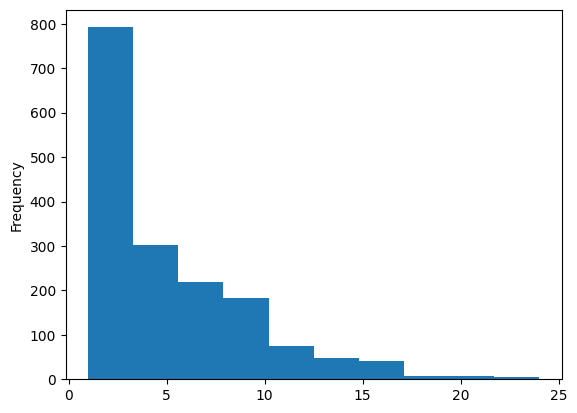

In [34]:
grouped_ratings['num_ratings'].plot.hist()

Теперь, когда мы сгруппировали все оценки каждого пользователя, давайте разделим их на более мелкие последовательности. Чтобы максимально эффективно использовать данные, мы хотели бы, чтобы модель имела возможность прогнозировать рейтинг каждого фильма в обучающем наборе. Для этого давайте укажем длину последовательности s и будем использовать предыдущие рейтинги s-1 в качестве нашей пользовательской истории.

Поскольку модель ожидает, что каждая последовательность будет иметь фиксированную длину, мы заполним пустые места маркером заполнения, чтобы последовательности можно было группировать и передавать в модель. Давайте создадим функцию для этого.

Здесь мы произвольно выберем длину 10.

In [35]:
sequence_length = 10

In [36]:
def create_sequences(values, sequence_length):
    sequences = []
    for i, v in enumerate(values):
        seq = values[:i+1]
        if len(seq) > sequence_length:
            seq = seq[i-sequence_length+1:i+1]
        elif len(seq) < sequence_length:
            seq =(*(['[PAD]'] * (sequence_length - len(seq))), *seq)

        sequences.append(seq)
    return sequences


In [37]:
grouped_ratings.iloc[0]['title'][:10]

('Построение долгосрочных отношений с клиентами: Техники и методы',
 'Использование эмоционального интеллекта в общении с клиентами',
 'Основы психологии клиентского обслуживания',
 'Развитие навыков эмпатии в клиентском обслуживании',
 'Эффективное планирование и организация работы в клиентском сервисе')

In [38]:
create_sequences(grouped_ratings.iloc[0]['title'][:10], 3)

[('[PAD]',
  '[PAD]',
  'Построение долгосрочных отношений с клиентами: Техники и методы'),
 ('[PAD]',
  'Построение долгосрочных отношений с клиентами: Техники и методы',
  'Использование эмоционального интеллекта в общении с клиентами'),
 ('Построение долгосрочных отношений с клиентами: Техники и методы',
  'Использование эмоционального интеллекта в общении с клиентами',
  'Основы психологии клиентского обслуживания'),
 ('Использование эмоционального интеллекта в общении с клиентами',
  'Основы психологии клиентского обслуживания',
  'Развитие навыков эмпатии в клиентском обслуживании'),
 ('Основы психологии клиентского обслуживания',
  'Развитие навыков эмпатии в клиентском обслуживании',
  'Эффективное планирование и организация работы в клиентском сервисе')]

In [39]:
grouped_cols = ['title', 'rating', 'unix_timestamp', 'is_valid']
for col in grouped_cols:
    grouped_ratings[col] = grouped_ratings[col].apply(lambda x: create_sequences(x, sequence_length))

В настоящее время у нас есть одна строка, содержащая все последовательности для определенного пользователя. Однако во время обучения нам хотелось бы создавать пакеты, состоящие из последовательностей от разных пользователей. Для этого нам придется преобразовать данные так, чтобы каждая последовательность имела свою строку, оставаясь при этом связанной с идентификатором пользователя. Мы можем использовать функцию «развернуть» pandas для каждой функции, а затем агрегировать эти DataFrames вместе.

In [40]:
exploded_ratings = grouped_ratings[['user_id', 'title']].explode('title', ignore_index=True)
dfs = [grouped_ratings[[col]].explode(col, ignore_index=True) for col in grouped_cols[1:]]
seq_df = pd.concat([exploded_ratings, *dfs], axis=1)

Теперь мы видим, что каждая последовательность имеет свою собственную строку. Однако для столбца is_valid нас не интересует вся последовательность, нам нужно только последнее значение, поскольку это курс, для которого мы будем пытаться предсказать рейтинг. Давайте создадим функцию для извлечения этого значения и применения его к этим столбцам.

In [41]:
def get_last_entry(sequence):
    return sequence[-1]

seq_df['is_valid'] = seq_df['is_valid'].apply(get_last_entry)

In [42]:
seq_df['target_rating'] = seq_df['rating'].apply(get_last_entry)
seq_df['previous_ratings'] = seq_df['rating'].apply(lambda seq: seq[:-1])
seq_df.drop(columns=['rating'], inplace=True)

Чтобы модель не включала маркеры заполнения при вычислении оценок внимания, мы можем предоставить преобразователю маску внимания; маска должна быть «True» для маркера заполнения и «False» в противном случае. Давайте посчитаем это для каждой строки, а также создадим столбец, чтобы показать количество присутствующих токенов заполнения.

In [43]:
seq_df['pad_mask'] = seq_df['title'].apply(lambda x: (np.array(x) == '[PAD]'))
seq_df['num_pads'] = seq_df['pad_mask'].apply(sum)
seq_df['pad_mask'] = seq_df['pad_mask'].apply(lambda x: x.tolist())

In [44]:
train_seq_df = seq_df[seq_df.is_valid == False]
valid_seq_df = seq_df[seq_df.is_valid == True]

**Training**

прежде чем мы сможем передать эти данные в модель, нам необходимо создать справочные таблицы для кодирования наших курсов и пользователей. Однако на этот раз нам нужно включить токен заполнения в наш поиск курса

In [45]:
user_lookup = {v: i+1 for i, v in enumerate(ratings_df['user_id'].unique())}

In [46]:
def create_feature_lookup(df, feature):
    lookup = {v: i+1 for i, v in enumerate(df[feature].unique())}
    lookup['[PAD]'] = 0
    return lookup

In [47]:
course_lookup = create_feature_lookup(ratings_df, 'title')

Сейчас мы имеем дело с последовательностями рейтингов, а не с отдельными, поэтому нам нужно будет создать новый набор данных, чтобы обернуть наш обработанный DataFrame:

In [48]:
class CourseSequenceDataset(Dataset):
    def __init__(self, df, course_lookup, user_lookup):
        super().__init__()
        self.df = df
        self.course_lookup = course_lookup
        self.user_lookup = user_lookup

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data = self.df.iloc[index]
        user_id = self.user_lookup[str(data.user_id)]
        course_ids = torch.tensor([self.course_lookup[title] for title in data.title])

        previous_ratings = torch.tensor(
            [rating if rating != "[PAD]" else 0 for rating in data.previous_ratings]
        )

        attention_mask = torch.tensor(data.pad_mask)
        target_rating = data.target_rating
        encoded_features = {
            "user_id": user_id,
            "course_ids": course_ids,
            "ratings": previous_ratings,
        }

        return (encoded_features, attention_mask), torch.tensor(
            target_rating, dtype=torch.float32
        )


In [49]:
train_dataset = CourseSequenceDataset(train_seq_df, course_lookup, user_lookup)
valid_dataset = CourseSequenceDataset(valid_seq_df, course_lookup, user_lookup)

In [50]:
train_seq_df.target_rating.unique()

array([5, 2, 3, 4, 1])

In [51]:
train_seq_df.previous_ratings

0       ([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...
1       ([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...
2       ([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...
3       ([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 5, ...
5       ([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...
                              ...                        
8398    ([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...
8399    ([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...
8400    ([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 5, ...
8401      ([PAD], [PAD], [PAD], [PAD], [PAD], 5, 5, 5, 5)
8402          ([PAD], [PAD], [PAD], [PAD], 5, 5, 5, 5, 5)
Name: previous_ratings, Length: 6727, dtype: object

Для начала, учитывая, что модель матричной факторизации может обеспечить хорошую производительность, используя только идентификаторы пользователя и фильма, давайте пока включим только эту информацию.

In [52]:
class BstTransformer(nn.Module):
    def __init__(
        self,
        courses_num_unique,
        users_num_unique,
        sequence_length=10,
        embedding_size=120,
        num_transformer_layers=1,
        ratings_range=(0.5, 5.5),
    ):
        super().__init__()
        self.sequence_length = sequence_length
        self.y_range = ratings_range
        self.courses_embeddings = nn.Embedding(
            courses_num_unique + 1, embedding_size, padding_idx=0
        )
        self.user_embeddings = nn.Embedding(users_num_unique + 1, embedding_size)
        self.position_embeddings = nn.Embedding(sequence_length, embedding_size)

        self.encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=12,
                dropout=0.1,
                batch_first=True,
                activation="gelu",
            ),
            num_layers=num_transformer_layers,
        )

        self.linear = nn.Sequential(
            nn.Linear(
                embedding_size + (embedding_size * sequence_length),
                1024,
            ),
            nn.BatchNorm1d(1024),
            nn.Mish(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Mish(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Mish(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        features, mask = inputs

        encoded_user_id = self.user_embeddings(features["user_id"])

        user_features = encoded_user_id

        encoded_courses = self.courses_embeddings(features["course_ids"])

        positions = torch.arange(
            0, self.sequence_length, 1, dtype=int, device=features["course_ids"].device
        )
        positions = self.position_embeddings(positions)

        transformer_features = encoded_courses + positions

        transformer_output = self.encoder(
            transformer_features, src_key_padding_mask=mask
        )
        transformer_output = torch.flatten(transformer_output, start_dim=1)

        combined_output = torch.cat((transformer_output, user_features), dim=1)

        rating = self.linear(combined_output)
        rating = rating.squeeze()
        if self.y_range is None:
            return rating
        else:
            return rating * (self.y_range[1] - self.y_range[0]) + self.y_range[0]


Мы видим, что по умолчанию мы помещаем нашу последовательность вложений курсов в один слой преобразователя, а затем объединяем выходные данные с пользовательскими функциями здесь, только идентификатор пользователя и используем это в качестве входных данных для полностью подключенной сети. Здесь мы используем только простое позиционное кодирование, которое обучено представлять последовательность, в которой оценивались курсы; использование подхода, основанного на синусоидах и косинусах, не принесло никакой пользы.

Еще раз давайте определим обучающую функцию для этой модели; за исключением инициализации модели, она идентична той, которую мы использовали для обучения модели матричной факторизации.

In [53]:
def train_seq_model():
    model = BstTransformer(
        len(course_lookup), len(user_lookup), sequence_length, embedding_size=120
    )
    loss_func = torch.nn.MSELoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

    create_sched_fn = partial(
        torch.optim.lr_scheduler.OneCycleLR,
        max_lr=0.01,
        epochs=TrainerPlaceholderValues.NUM_EPOCHS,
        steps_per_epoch=TrainerPlaceholderValues.NUM_UPDATE_STEPS_PER_EPOCH,
    )

    trainer = Trainer(
        model=model,
        loss_func=loss_func,
        optimizer=optimizer,
        callbacks=(
            RecommenderMetricsCallback,
            *DEFAULT_CALLBACKS,
            SaveBestModelCallback(watch_metric="mae"),
            EarlyStoppingCallback(
                early_stopping_patience=2,
                early_stopping_threshold=0.001,
                watch_metric="mae",
            ),
        ),
    )

    trainer.train(
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        num_epochs=10,
        per_device_batch_size=32,
        create_scheduler_fn=create_sched_fn,
    )


In [54]:
notebook_launcher(train_seq_model, num_processes=2)

Launching training on one CPU.

Starting training run

Starting epoch 1


  0%|          | 0/211 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████▉| 210/211 [00:25<00:00,  2.88it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 211/211 [00:25<00:00,  8.14it/s]



train_loss_epoch: 1.9015356302261353


100%|██████████| 53/53 [00:05<00:00,  9.68it/s]



mse: 1.666195273399353

mae: 1.0698065757751465

eval_loss_epoch: 1.666195273399353

rmse: 1.2908118659972696

Starting epoch 2


100%|██████████| 211/211 [00:23<00:00,  8.97it/s]



train_loss_epoch: 1.232917308807373


100%|██████████| 53/53 [00:01<00:00, 26.58it/s]



mse: 1.2540837526321411

mae: 0.895598292350769

eval_loss_epoch: 1.2540838718414307

rmse: 1.1198588092398707

Improvement of 0.17420828342437744 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 3


100%|██████████| 211/211 [00:20<00:00, 10.10it/s]



train_loss_epoch: 0.7605065107345581


100%|██████████| 53/53 [00:01<00:00, 32.13it/s]



mse: 1.237689733505249

mae: 0.8906693458557129

eval_loss_epoch: 1.237689733505249

rmse: 1.1125150486646231

Improvement of 0.004928946495056152 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 4


100%|██████████| 211/211 [00:21<00:00,  9.64it/s]



train_loss_epoch: 0.5789235830307007


100%|██████████| 53/53 [00:01<00:00, 32.44it/s]



mse: 1.110611915588379

mae: 0.8462344408035278

eval_loss_epoch: 1.1106117963790894

rmse: 1.0538557375601174

Improvement of 0.04443490505218506 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 5


100%|██████████| 211/211 [00:31<00:00,  6.64it/s]



train_loss_epoch: 0.5150419473648071


100%|██████████| 53/53 [00:02<00:00, 21.53it/s]



mse: 1.1563301086425781

mae: 0.8505905270576477

eval_loss_epoch: 1.1563302278518677

rmse: 1.075327907497326
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 1/2

Starting epoch 6


100%|██████████| 211/211 [00:19<00:00, 10.71it/s]



train_loss_epoch: 0.4741964638233185


100%|██████████| 53/53 [00:01<00:00, 33.13it/s]



mse: 1.1226476430892944

mae: 0.8163647055625916

eval_loss_epoch: 1.1226475238800049

rmse: 1.0595506798116334

Improvement of 0.02986973524093628 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 7


100%|██████████| 211/211 [00:20<00:00, 10.27it/s]



train_loss_epoch: 0.40541842579841614


100%|██████████| 53/53 [00:01<00:00, 32.81it/s]



mse: 1.0693517923355103

mae: 0.7872511744499207

eval_loss_epoch: 1.0693517923355103

rmse: 1.03409467281072

Improvement of 0.0291135311126709 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 8


100%|██████████| 211/211 [00:20<00:00, 10.30it/s]



train_loss_epoch: 0.36745449900627136


100%|██████████| 53/53 [00:02<00:00, 25.41it/s]



mse: 1.0694233179092407

mae: 0.7900968790054321

eval_loss_epoch: 1.0694233179092407

rmse: 1.034129255900461
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 1/2

Starting epoch 9


100%|██████████| 211/211 [00:18<00:00, 11.33it/s]



train_loss_epoch: 0.3212393820285797


100%|██████████| 53/53 [00:01<00:00, 32.74it/s]


mse: 1.0989314317703247

mae: 0.7953154444694519

eval_loss_epoch: 1.0989315509796143

rmse: 1.048299304478604
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 2/2
Stopping training due to no improvement after 2 epochs
Finishing training run
Loading checkpoint with mae: 0.7872511744499207 from epoch 7


Мы видим, что это значительное улучшение по сравнению с подходом матричной факторизации и базовой моделью

**Добавление дополнительных данных**

До сих пор для прогнозирования рейтинга мы рассматривали только идентификатор пользователя и последовательность идентификаторов курсов; вполне вероятно, что включение информации о предыдущих оценках пользователя улучшит производительность. К счастью, это легко сделать, и наш набор данных уже возвращает данные. Давайте изменим нашу архитектуру, включив в нее следующее:

In [55]:
class BstTransformer(nn.Module):
    def __init__(
        self,
        courses_num_unique,
        users_num_unique,
        sequence_length=10,
        embedding_size=120,
        num_transformer_layers=1,
        ratings_range=(0.5, 5.5),
    ):
        super().__init__()
        self.sequence_length = sequence_length
        self.y_range = ratings_range
        self.courses_embeddings = nn.Embedding(
            courses_num_unique + 1, embedding_size, padding_idx=0
        )
        self.user_embeddings = nn.Embedding(users_num_unique + 1, embedding_size)
        self.ratings_embeddings = nn.Embedding(6, embedding_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(sequence_length, embedding_size)

        self.encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=12,
                dropout=0.1,
                batch_first=True,
                activation="gelu",
            ),
            num_layers=num_transformer_layers,
        )

        self.linear = nn.Sequential(
            nn.Linear(
                embedding_size + (embedding_size * sequence_length),
                1024,
            ),
            nn.BatchNorm1d(1024),
            nn.Mish(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Mish(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Mish(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        features, mask = inputs

        encoded_user_id = self.user_embeddings(features["user_id"])

        user_features = encoded_user_id

        course_history = features["course_ids"][:, :-1]
        target_course = features["course_ids"][:, -1]

        ratings = self.ratings_embeddings(features["ratings"])

        encoded_courses = self.courses_embeddings(course_history)
        encoded_target_course = self.courses_embeddings(target_course)

        positions = torch.arange(
            0,
            self.sequence_length - 1,
            1,
            dtype=int,
            device=features["course_ids"].device,
        )
        positions = self.position_embeddings(positions)

        encoded_sequence_courses_with_position_and_rating = (
            encoded_courses + ratings + positions
        )
        encoded_target_course = encoded_target_course.unsqueeze(1)

        transformer_features = torch.cat(
            (encoded_sequence_courses_with_position_and_rating, encoded_target_course),
            dim=1,
        )
        transformer_output = self.encoder(
            transformer_features, src_key_padding_mask=mask
        )
        transformer_output = torch.flatten(transformer_output, start_dim=1)

        combined_output = torch.cat((transformer_output, user_features), dim=1)

        rating = self.linear(combined_output)
        rating = rating.squeeze()
        if self.y_range is None:
            return rating
        else:
            return rating * (self.y_range[1] - self.y_range[0]) + self.y_range[0]


Мы видим, что для использования данных рейтингов мы добавили дополнительный слой внедрения. Затем для каждого курсса с ранее присвоенным рейтингом мы суммируем встраивание курса, позиционное кодирование и встраивание рейтинга, прежде чем подавать эту последовательность в преобразователь. В качестве альтернативы данные рейтинга можно было бы объединить или умножить на встраивание курса, но их объединение сработало лучше всего из опробованных мной подходов.

Поскольку Jupyter поддерживает актуальное состояние для каждого определения класса, нам не нужно обновлять нашу обучающую функцию; новый класс будет использоваться, когда мы начнем обучение:

In [56]:
notebook_launcher(train_seq_model, num_processes=2)

Launching training on one CPU.

Starting training run

Starting epoch 1


100%|██████████| 211/211 [00:22<00:00,  9.32it/s]



train_loss_epoch: 0.9643571376800537


100%|██████████| 53/53 [00:01<00:00, 32.81it/s]



mse: 0.947973370552063

mae: 0.7791383266448975

eval_loss_epoch: 0.9479734301567078

rmse: 0.9736392404541134

Starting epoch 2


100%|██████████| 211/211 [00:21<00:00,  9.68it/s]



train_loss_epoch: 0.8985363841056824


100%|██████████| 53/53 [00:01<00:00, 32.86it/s]



mse: 1.0532605648040771

mae: 0.7264193296432495

eval_loss_epoch: 1.0532605648040771

rmse: 1.0262848360976973

Improvement of 0.05271899700164795 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 3


100%|██████████| 211/211 [00:21<00:00,  9.60it/s]



train_loss_epoch: 0.8623473048210144


100%|██████████| 53/53 [00:01<00:00, 32.29it/s]



mse: 0.9331973195075989

mae: 0.7673484683036804

eval_loss_epoch: 0.9331973195075989

rmse: 0.9660213866719509
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 1/2

Starting epoch 4


100%|██████████| 211/211 [00:21<00:00,  9.63it/s]



train_loss_epoch: 0.6034365892410278


100%|██████████| 53/53 [00:02<00:00, 21.77it/s]


mse: 0.9482542276382446

mae: 0.7475705146789551

eval_loss_epoch: 0.9482539892196655

rmse: 0.9737834603433376
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 2/2
Stopping training due to no improvement after 2 epochs
Finishing training run
Loading checkpoint with mae: 0.7264193296432495 from epoch 2


Видим улучшение

**Добавление пользовательских функций**

Помимо данных рейтингов, у нас также есть дополнительная информация о пользователях, которую мы могли бы добавить в модель.

In [57]:
binned = pd.cut(employees.age, bins=[-np.inf, 17, 25, 35, 45, 55, np.inf])

In [58]:
employees['age_group'] = binned


In [59]:
binned_ = pd.cut(employees.exp_days, 10)

In [60]:
employees['exp_days_group'] = binned_

In [61]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

employees['sex_encoded'] = le.fit_transform(employees.sex)
employees['age_group_encoded'] = le.fit_transform(employees.age_group)
employees['region_encoded'] = le.fit_transform(employees.region)
employees['head_employee_id_encoded'] = le.fit_transform(employees.head_employee_id)
employees['exp_days_group_encoded'] = le.fit_transform(employees.exp_days_group)
employees['edu_degree_encoded'] = le.fit_transform(employees.edu_degree)
employees['department_id_encoded'] = le.fit_transform(employees.department_id)


In [62]:
prep=employees[['employee_id','sex_encoded','age_group_encoded','region_encoded',
                                                     'head_employee_id_encoded','exp_days_group_encoded','edu_degree_encoded',
                                                     'department_id_encoded','work_online_flg']].rename(columns={'employee_id':'user_id'})

In [63]:
seq_with_user_features = pd.merge(seq_df, prep, how='left', on='user_id')


In [64]:
seq_with_user_features.head(3)

,user_id,title,unix_timestamp,is_valid,target_rating,previous_ratings,pad_mask,num_pads,sex_encoded,age_group_encoded,region_encoded,head_employee_id_encoded,exp_days_group_encoded,edu_degree_encoded,department_id_encoded,work_online_flg
0,00411460-f7c9-2d21-24a6-7ea0f4cb5f85,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,5,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Tru...",9,0,1,3,30,1,1,1,1
1,00411460-f7c9-2d21-24a6-7ea0f4cb5f85,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,5,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Tru...",8,0,1,3,30,1,1,1,1
2,00411460-f7c9-2d21-24a6-7ea0f4cb5f85,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,5,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Fal...",7,0,1,3,30,1,1,1,1


In [65]:
train_df = seq_with_user_features[seq_with_user_features.is_valid == False]
valid_df = seq_with_user_features[seq_with_user_features.is_valid == True]

In [66]:
class CourseSequenceDataset(Dataset):
    def __init__(self, df, course_lookup, user_lookup):
        super().__init__()
        self.df = df
        self.course_lookup = course_lookup
        self.user_lookup = user_lookup

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data = self.df.iloc[index]
        user_id = self.user_lookup[str(data.user_id)]
        course_ids = torch.tensor([self.course_lookup[title] for title in data.title])

        previous_ratings = torch.tensor(
            [rating if rating != "[PAD]" else 0 for rating in data.previous_ratings]
        )

        attention_mask = torch.tensor(data.pad_mask)
        target_rating = data.target_rating
        encoded_features = {
            "user_id": user_id,
            "course_ids": course_ids,
            "ratings": previous_ratings,
            "age_group": data["age_group_encoded"],
            "sex": data["sex_encoded"],
            "region": data["region_encoded"],
            "head_employee_id": data["head_employee_id_encoded"],
            "exp_days_group": data["exp_days_group_encoded"],
            "edu_degree": data["edu_degree_encoded"],
            "department_id": data["department_id_encoded"],
            "work_online_flg": data["work_online_flg"],
        }

        return (encoded_features, attention_mask), torch.tensor(
            target_rating, dtype=torch.float32
        )


In [67]:
train_dataset = CourseSequenceDataset(train_df, course_lookup, user_lookup)
valid_dataset = CourseSequenceDataset(valid_df, course_lookup, user_lookup)

Теперь мы можем изменить нашу архитектуру, включив в нее внедрения для этих функций и объединить эти внедрения с выходными данными преобразователя; затем мы передаем это в сеть прямой связи.

In [68]:
class BstTransformer(nn.Module):
    def __init__(
        self,
        courses_num_unique,
        users_num_unique,
        sequence_length=10,
        embedding_size=120,
        num_transformer_layers=1,
        ratings_range=(0.5, 5.5),
    ):
        super().__init__()
        self.sequence_length = sequence_length
        self.y_range = ratings_range
        self.courses_embeddings = nn.Embedding(
            courses_num_unique + 1, embedding_size, padding_idx=0
        )
        self.user_embeddings = nn.Embedding(users_num_unique + 1, embedding_size)
        self.ratings_embeddings = nn.Embedding(6, embedding_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(sequence_length, embedding_size)

        self.sex_embeddings = nn.Embedding(
            len(employees.sex.unique()),
            2,
        )
        self.age_group_embeddings = nn.Embedding(
            len(employees.age_group.unique()),
            4,
        )
        self.region_embeddings = nn.Embedding(
            len(employees.region.unique()),
            2,
        )
        self.head_employee_id_embeddings = nn.Embedding(
            len(employees.head_employee_id.unique()),
            11,
        )
        self.exp_days_group_embeddings = nn.Embedding(
            len(employees.exp_days_group.unique()),
            4,
        )
        self.edu_degree_embeddings = nn.Embedding(
            len(employees.edu_degree.unique()),
            2,
        )
        self.department_id_embeddings = nn.Embedding(
            len(employees.department_id.unique()),
            2,
        )
        self.work_online_flg_embeddings = nn.Embedding(
            len(employees.work_online_flg.unique()),
            2,
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=12,
                dropout=0.1,
                batch_first=True,
                activation="gelu",
            ),
            num_layers=num_transformer_layers,
        )

        self.linear = nn.Sequential(
            nn.Linear(
                embedding_size + (embedding_size * sequence_length) + 2 + 4 + 2 + 4 + 2, # + 11 + 2 + 2
                1024,
            ),
            nn.BatchNorm1d(1024),
            nn.Mish(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Mish(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Mish(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        features, mask = inputs

        user_id = self.user_embeddings(features["user_id"])

        age_group = self.age_group_embeddings(features["age_group"])
        sex = self.sex_embeddings(features["sex"])
        region = self.region_embeddings(features["region"])
        #head_employee_id = self.head_employee_id_embeddings(features["head_employee_id"])
        exp_days_group = self.exp_days_group_embeddings(features["exp_days_group"])
        edu_degree = self.edu_degree_embeddings(features["edu_degree"])
        #department_id = self.department_id_embeddings(features["department_id"])
        #work_online_flg = self.work_online_flg_embeddings(features["work_online_flg"])


        user_features = user_features = torch.cat(
            (user_id, sex, age_group, region, exp_days_group, edu_degree), 1 #, head_employee_id, department_id, work_online_flg
        )

        course_history = features["course_ids"][:, :-1]
        target_course = features["course_ids"][:, -1]

        ratings = self.ratings_embeddings(features["ratings"])

        encoded_courses = self.courses_embeddings(course_history)
        encoded_target_course = self.courses_embeddings(target_course)

        positions = torch.arange(
            0,
            self.sequence_length - 1,
            1,
            dtype=int,
            device=features["course_ids"].device,
        )
        positions = self.position_embeddings(positions)

        encoded_sequence_courses_with_position_and_rating = (
            encoded_courses + ratings + positions
        )
        encoded_target_course = encoded_target_course.unsqueeze(1)

        transformer_features = torch.cat(
            (encoded_sequence_courses_with_position_and_rating, encoded_target_course),
            dim=1,
        )
        transformer_output = self.encoder(
            transformer_features, src_key_padding_mask=mask
        )
        transformer_output = torch.flatten(transformer_output, start_dim=1)

        combined_output = torch.cat((transformer_output, user_features), dim=1)

        rating = self.linear(combined_output)
        rating = rating.squeeze()
        if self.y_range is None:
            return rating
        else:
            return rating * (self.y_range[1] - self.y_range[0]) + self.y_range[0]


In [69]:
notebook_launcher(train_seq_model, num_processes=2)

Launching training on one CPU.

Starting training run

Starting epoch 1


  0%|          | 0/211 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████▉| 210/211 [00:23<00:00,  7.18it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 211/211 [00:23<00:00,  8.83it/s]



train_loss_epoch: 0.9691553711891174


100%|██████████| 53/53 [00:02<00:00, 21.26it/s]



mse: 0.9231170415878296

mae: 0.7396212816238403

eval_loss_epoch: 0.9231171011924744

rmse: 0.9607898009387015

Starting epoch 2


100%|██████████| 211/211 [00:25<00:00,  8.25it/s]



train_loss_epoch: 0.893917441368103


100%|██████████| 53/53 [00:01<00:00, 27.49it/s]



mse: 0.9699275493621826

mae: 0.7309500575065613

eval_loss_epoch: 0.9699274897575378

rmse: 0.9848489982541397

Improvement of 0.008671224117279053 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 3


100%|██████████| 211/211 [00:24<00:00,  8.59it/s]



train_loss_epoch: 0.8912466168403625


100%|██████████| 53/53 [00:02<00:00, 26.23it/s]



mse: 0.9052268266677856

mae: 0.7512356042861938

eval_loss_epoch: 0.9052267670631409

rmse: 0.9514340895026757
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 1/2

Starting epoch 4


100%|██████████| 211/211 [00:26<00:00,  8.07it/s]



train_loss_epoch: 0.5940999388694763


100%|██████████| 53/53 [00:01<00:00, 27.28it/s]


mse: 0.9380069971084595

mae: 0.7446690201759338

eval_loss_epoch: 0.9380069971084595

rmse: 0.9685076133456357
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 2/2
Stopping training due to no improvement after 2 epochs
Finishing training run
Loading checkpoint with mae: 0.7309500575065613 from epoch 2


Видим улучшение

**Получение рекомендаций**

In [70]:
ratings_df[ratings_df['user_id']=='00411460-f7c9-2d21-24a6-7ea0f4cb5f85'].title.unique()

array(['Построение долгосрочных отношений с клиентами: Техники и методы',
       'Развитие навыков эмпатии в клиентском обслуживании',
       'Основы психологии клиентского обслуживания',
       'Использование эмоционального интеллекта в общении с клиентами',
       'Эффективное планирование и организация работы в клиентском сервисе'],
      dtype=object)

In [72]:
def train_seq_model():
    model = BstTransformer(
        len(course_lookup), len(user_lookup), sequence_length, embedding_size=120
    )
    loss_func = torch.nn.MSELoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

    create_sched_fn = partial(
        torch.optim.lr_scheduler.OneCycleLR,
        max_lr=0.01,
        epochs=TrainerPlaceholderValues.NUM_EPOCHS,
        steps_per_epoch=TrainerPlaceholderValues.NUM_UPDATE_STEPS_PER_EPOCH,
    )

    trainer = Trainer(
        model=model,
        loss_func=loss_func,
        optimizer=optimizer,
        callbacks=(
            RecommenderMetricsCallback,
            *DEFAULT_CALLBACKS,
            SaveBestModelCallback(watch_metric="mae"),
            EarlyStoppingCallback(
                early_stopping_patience=2,
                early_stopping_threshold=0.001,
                watch_metric="mae",
            ),
        ),
    )

    trainer.train(
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        num_epochs=10,
        per_device_batch_size=32,
        create_scheduler_fn=create_sched_fn,
    )
    PATH = "entire_model.pt"
    torch.save(model, PATH)


In [73]:
notebook_launcher(train_seq_model, num_processes=2)

Launching training on one CPU.

Starting training run

Starting epoch 1


100%|██████████| 211/211 [00:23<00:00,  8.90it/s]



train_loss_epoch: 0.9691553711891174


100%|██████████| 53/53 [00:02<00:00, 26.42it/s]



mse: 0.9231170415878296

mae: 0.7396212816238403

eval_loss_epoch: 0.9231171011924744

rmse: 0.9607898009387015

Starting epoch 2


100%|██████████| 211/211 [00:24<00:00,  8.55it/s]



train_loss_epoch: 0.893917441368103


100%|██████████| 53/53 [00:01<00:00, 26.54it/s]



mse: 0.9699275493621826

mae: 0.7309500575065613

eval_loss_epoch: 0.9699274897575378

rmse: 0.9848489982541397

Improvement of 0.008671224117279053 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 3


100%|██████████| 211/211 [00:24<00:00,  8.57it/s]



train_loss_epoch: 0.8912466168403625


100%|██████████| 53/53 [00:01<00:00, 26.58it/s]



mse: 0.9052268266677856

mae: 0.7512356042861938

eval_loss_epoch: 0.9052267670631409

rmse: 0.9514340895026757
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 1/2

Starting epoch 4


100%|██████████| 211/211 [00:24<00:00,  8.52it/s]



train_loss_epoch: 0.5940999388694763


100%|██████████| 53/53 [00:01<00:00, 26.54it/s]



mse: 0.9380069971084595

mae: 0.7446690201759338

eval_loss_epoch: 0.9380069971084595

rmse: 0.9685076133456357
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 2/2
Stopping training due to no improvement after 2 epochs
Finishing training run
Loading checkpoint with mae: 0.7309500575065613 from epoch 2


In [74]:
model = BstTransformer(
        len(course_lookup), len(user_lookup), sequence_length, embedding_size=120
    )
PATH = "entire_model.pt"
model = torch.load(PATH)
model.eval()

BstTransformer(
  (courses_embeddings): Embedding(94, 120, padding_idx=0)
  (user_embeddings): Embedding(1678, 120)
  (ratings_embeddings): Embedding(6, 120, padding_idx=0)
  (position_embeddings): Embedding(10, 120)
  (sex_embeddings): Embedding(2, 2)
  (age_group_embeddings): Embedding(5, 4)
  (region_embeddings): Embedding(8, 2)
  (head_employee_id_embeddings): Embedding(132, 11)
  (exp_days_group_embeddings): Embedding(10, 4)
  (edu_degree_embeddings): Embedding(3, 2)
  (department_id_embeddings): Embedding(3, 2)
  (work_online_flg_embeddings): Embedding(2, 2)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=120, out_features=120, bias=True)
        )
        (linear1): Linear(in_features=120, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=120,

In [85]:
from torch.utils.data import DataLoader
from datetime import datetime

def inference(user_id, title):
  user_rating_df = ratings_df[ratings_df['user_id'] == user_id]
  user_rating_df['is_valid'] = False
  user_fields = pd.DataFrame([[user_id, title, ratings_df.unix_timestamp.max(), 0, True]],
                              columns=['user_id', 'title', 'unix_timestamp', 'rating', 'is_valid'])

  final_df = pd.concat([user_rating_df, user_fields], axis=0)

  # print(valid_df)
  grouped_ratings = final_df.sort_values(by='unix_timestamp').groupby('user_id').agg(tuple).reset_index()
  # grouped_ratings = ratings_df.sort_values(by='unix_timestamp').groupby('user_id').agg(tuple).reset_index()
  grouped_cols = ['title', 'rating', 'unix_timestamp', 'is_valid']
  for col in grouped_cols:
      grouped_ratings[col] = grouped_ratings[col].apply(lambda x: create_sequences(x, sequence_length))

  exploded_ratings = grouped_ratings[['user_id', 'title']].explode('title', ignore_index=True)
  dfs = [grouped_ratings[[col]].explode(col, ignore_index=True) for col in grouped_cols[1:]]
  seq_df = pd.concat([exploded_ratings, *dfs], axis=1)
  seq_df['is_valid'] = seq_df['is_valid'].apply(get_last_entry)

  seq_df['target_rating'] = seq_df['rating'].apply(get_last_entry)
  seq_df['previous_ratings'] = seq_df['rating'].apply(lambda seq: seq[:-1])
  seq_df.drop(columns=['rating'], inplace=True)

  seq_df['pad_mask'] = seq_df['title'].apply(lambda x: (np.array(x) == '[PAD]'))
  seq_df['num_pads'] = seq_df['pad_mask'].apply(sum)
  seq_df['pad_mask'] = seq_df['pad_mask'].apply(lambda x: x.tolist())

  seq_with_user_features = pd.merge(seq_df, prep, how='left', on='user_id')
  valid_df = seq_with_user_features[seq_with_user_features.is_valid == True]
  valid_dataset = CourseSequenceDataset(valid_df, course_lookup, user_lookup)
  valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)
  # print(valid_df)
  # return 1
  for test_inputs, test_labels in valid_loader:
    return model(test_inputs)


In [86]:
res=inference('00411460-f7c9-2d21-24a6-7ea0f4cb5f85','Построение эффективных команд в клиентском обслуживании')

<ipython-input-85-e2434bc981b4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_rating_df['is_valid'] = False


In [96]:
res.detach().numpy().tolist()

4.246519088745117

In [93]:
result = {}

In [97]:
for course in ratings_df.title.unique():
  res = inference('00411460-f7c9-2d21-24a6-7ea0f4cb5f85',course)
  result[course] = res.detach().numpy().tolist()


<ipython-input-85-e2434bc981b4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_rating_df['is_valid'] = False
<ipython-input-85-e2434bc981b4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_rating_df['is_valid'] = False
<ipython-input-85-e2434bc981b4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

**Топ 10 рекомендаций для пользователя**

In [102]:
sorted(result.items(), key=lambda x: x[1], reverse=True)[:10]

[('Использование мультимедийных инструментов в клиентском сервисе',
  4.279669761657715),
 ('Стратегии превентивного обслуживания клиентов: Предупреждение проблем',
  4.264876365661621),
 ('Основы психологии клиентского обслуживания', 4.263158798217773),
 ('Методы оценки и улучшения качества обслуживания клиентов',
  4.260293960571289),
 ('Использование эмоционального интеллекта в общении с клиентами',
  4.255990505218506),
 ('Как строить доверительные отношения с клиентами', 4.254293441772461),
 ('Продвинутые техники работы с жалобами клиентов', 4.253316402435303),
 ('Продвинутые методы анализа и интерпретации клиентских данных',
  4.251776695251465),
 ('Создание клиентоцентричной культуры в компании', 4.250155448913574),
 ('Развитие коммуникативных навыков в клиентском обслуживании',
  4.249379634857178)]